In [ ]:
!pip install emoji  # import library
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth',-1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=830f10980e25db85e3d64630609f3ead1720f54ca0f5fc7a18d8840d05e0621b
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Saving Tweets.csv to Tweets.csv


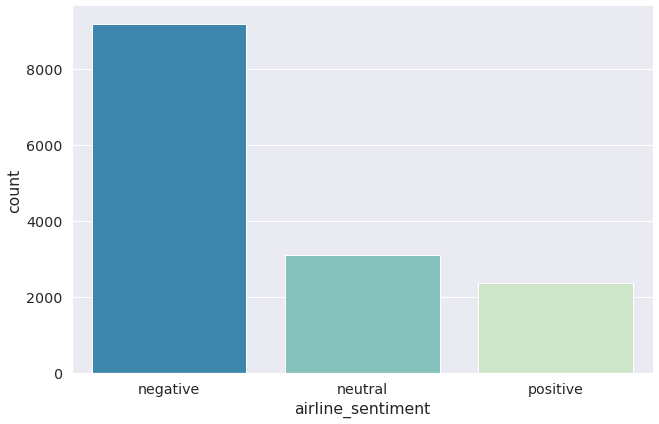

In [ ]:
import io # upload dataset from local machine and analyes
from google.colab import files

train_tsv =files.upload()
airlines_train=pd.read_csv(io.BytesIO(train_tsv['Tweets.csv']))
airlines_train=airlines_train.reindex(np.random.permutation(airlines_train.index))
airlines_train=airlines_train[['text','airline_sentiment']]

sns.factorplot(x="airline_sentiment",data=airlines_train,kind="count",size=6,aspect=1.5,palette="GnBu_r")
plt.show()

In [ ]:
#Now we are cleaning the text
class  CleanText(BaseEstimator,TransformerMixin):
  def remove_mentions(self,input_text):
    return re.sub(r'@\w+','',input_text)

  def remove_urls(self,input_text):
    return re.sub(r'http.?://[^\s]+[\s]?', '',input_text)
  
  def emoji_oneword(self,input_text):
    #By compressing the underscore the emoji is kept as one word
    return input_text.replace('_','')

  def remove_puncutions(self,input_text):
    #Make translation table
    punct=string.punctuation
    trantab=str.maketrans(punct,len(punct)*' ') # Every punctuation symbol will be replace by space
    return input_text.translate(trantab)

  def remove_digits(self,input_text):
    return re.sub('\d+','',input_text)
  
  def to_lower(self,input_text):
    return input_text.lower()
  
  def remove_stopwords(self,input_text):
    stopwords_list=stopwords.words("english")
    # some words which might indicate a certain sentiment are kept via a whitelist
    whitelist=["n't","not","no"]
    words=input_text.split()
    clean_words=[word for word in words if (word not in stopwords_list or word in whitelist) and len(word)>1]
    return " ".join(clean_words)
    
  def stemming(self,input_text):
    porter=PorterStemmer()
    stemmed_wods=[porter.stem(word) for word in words]
    return " ".join(stemmed_wods)

  def fit(self,clean_X,y=None,**fit_params):
    return self
  
  def transform(self,X,**transform_params):
    clean_X=X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_puncutions).apply(self.remove_digits)
    return clean_X

In [ ]:
import nltk  # used for clean stopwords
nltk.download('punkt')
nltk.download('stopwords')
ct=CleanText()
sr_clean=ct.fit_transform(airlines_train.text)
sr_clean.sample(5)
empty_clean=sr_clean== ''
print('{} record have no words left after clean text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean]='[no_text]'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0 record have no words left after clean text cleaning


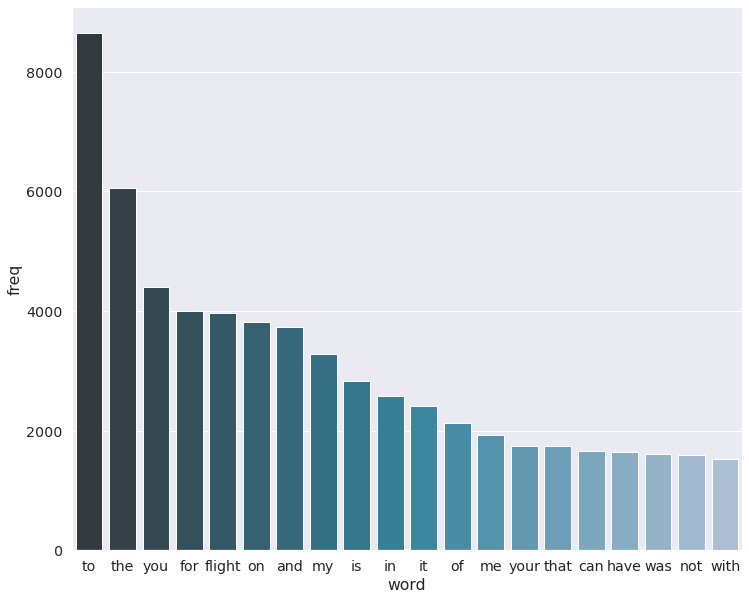

In [ ]:
cv=CountVectorizer()
bow=cv.fit_transform(sr_clean)
word_freq=dict(zip(cv.get_feature_names(),np.asarray(bow.sum(axis=0)).ravel()))
word_counter=collections.Counter(word_freq)
word_counter_df=pd.DataFrame(word_counter.most_common(20),columns=['word','freq'])
fig, ax =plt.subplots(figsize=(12,10))
sns.barplot(x="word",y="freq",data=word_counter_df,palette="PuBuGn_d",ax=ax)
plt.show();

In [ ]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [ ]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [ ]:
class ColumnExtractor(TransformerMixin,BaseEstimator):
  def __init__(self,cols):
    self.cols=cols
  def transform(self,X,**transform_params):
    return X[self.cols]
  def fit(self,X,y=None,**fit_params):
    return self
    

In [ ]:
class TextCounts(BaseEstimator,TransformerMixin):
  def count_regex(self,pattern,tweet):
    return len(re.findall(pattern,tweet))

  def fit(self,X,y=None,**fit_params): #Fit method is used eith spacific operational to be dione on the train data
    return self


  def transform(self,X,**transform_params):
    count_words=X.apply(lambda x: self.count_regex(r'\w+',x))
    count_mentions=X.apply(lambda x:self.count_regex(r'@\w+',x))
    count_hashtags=X.apply(lambda x: self.count_regex(r'#\w+',x))

    count_capital_words=X.apply(lambda x: self.count_regex(r'\b[A-z][2,]\b',x))

    count_excl_quest_marks=X.apply(lambda x: self.count_regex(r'!|\?',x))
    count_urls=X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?',x))

    count_emojis=X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:',x))


    df=pd.DataFrame({'count_words':count_words
                     ,'count_mentions':count_mentions
                     ,'count_hashtags':count_hashtags
                     ,'count_capital_words':count_capital_words
                     ,'count_excl_quest_marks':count_excl_quest_marks
                     ,'count_urls':count_urls
                     ,'count_emojis':count_emojis
                     })


    return df

tc=TextCounts()
airlines_eda=tc.fit_transform(airlines_train.text)
airlines_eda['airline_sentiment']=airlines_train.airline_sentiment

In [ ]:
df_model=airlines_eda
df_model['clean_text']=sr_clean
df_model.columns.tolist()
X_train,X_test,y_train,y_test=train_test_split(df_model.drop('airline_sentiment',axis=1),df_model.airline_sentiment,test_size=0.1,random_state=37)
mnb = MultinomialNB()
logreg = LogisticRegression()
countvect = CountVectorizer()
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
#joblib.dump(best_mnb_countvect, '../output/best_mnb_countvect.pkl')
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
#joblib.dump(best_logreg_countvect, '../output/best_logreg_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.3min finished


done in 80.867s

Best CV score: 0.792
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.805


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.82      0.94      0.87       911
     neutral       0.76      0.53      0.62       320
    positive       0.79      0.66      0.72       233

    accuracy                           0.80      1464
   macro avg       0.79      0.71      0.74      1464
weighted avg       0.80      0.80      0.79      1464

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.7min finished


done in 408.686s

Best CV score: 0.798
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.818


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88       911
     neutral       0.72      0.63      0.67       320
    positive       0.79      0.71      0.75       233

    accuracy                           0.82      1464
   macro avg       0.79      0.75      0.77      1464
weighted avg       0.81      0.82      0.81      1464

